В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        print("Layers: {}".format(self.layers))
        self.costs_iters = costs_iters
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __sigmoid_derivative(self, A):
        return np.multiply(A, 1 - A)
    
    def __softmax(self, Z):
        e = np.exp(Z)
        return e/np.sum(e, axis=0, keepdims=True)
    
    def __relu(self, Z):
        return np.maximum(0,Z)
    
    def __relu_derivative(self, A):
        return np.greater_equal(A, 0).astype(int)
    
    def __initialize_parameters(self):
        W, b = [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
        
        self.parameters = {"W" : W, "b" : b}
        
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers-1):
            Z_l = np.dot(W[l],A[l]) + b[l]
            #A_l = self.__sigmoid(Z_l)
            A_l = self.__relu(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        l = self.layers-1
        Z_l = np.dot(W[l],A[l]) + b[l]
        A_l = self.__softmax(Z_l)
        Z.append(Z_l)
        A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            #dZ_l = np.multiply(dA_l, self.__sigmoid_derivative(A[l]))
            dZ_l = np.multiply(dA_l, self.__relu_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        Y = Y.reshape((Y.shape[0], 1))
        enc = OneHotEncoder(handle_unknown='ignore')
        self.enc = enc
        Y = enc.fit_transform(Y).toarray().astype(int).T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        C = Y.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(C);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0].T
        return probs
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        max_cols = positive_probs.max(axis=1).reshape((-1,1))
        pred = (positive_probs == max_cols).astype(int)
        pred = self.enc.inverse_transform(pred)
        pred = pred.reshape((-1,)).T
        return pred

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

# Dataset

In [5]:
X, Y = load_iris(return_X_y = True)

In [6]:
cls = NeuralNet(layers_sizes = [30,20,10], normalize = True, 
                learning_rate = 0.1, num_iter = 10001, tol = 1e-8, costs_iters=1000)

Layers: 4


W1: (30, 4)
W2: (20, 30)
W3: (10, 20)
W4: (3, 10)
b1: (30, 1)
b2: (20, 1)
b3: (10, 1)
b4: (3, 1)
0-th iteration: 1.9095425960921755
1000-th iteration: 1.9095422356903646
2000-th iteration: 1.9095417284106098
3000-th iteration: 1.9095408401345852
4000-th iteration: 1.9095386833296073
5000-th iteration: 1.9095310921957431
6000-th iteration: 1.9094670402806575
7000-th iteration: 0.6254016723194276
8000-th iteration: 0.2514229705010678
9000-th iteration: 0.1617285356601385
10000-th iteration: 0.13350188354773043


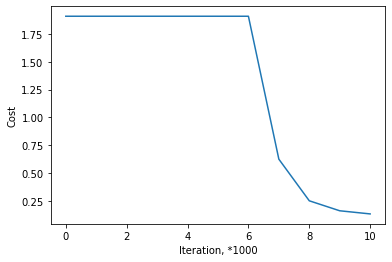

In [7]:
cls.fit(X, Y)

In [8]:
for key in cls.parameters:
    print("{}:\n".format(key))
    for i in cls.parameters[key]:
        print("{}\n".format(i))

W:

[[-4.36878272e-01  4.61513219e-01 -9.30348650e-01 -9.67005934e-01]
 [-4.06744971e-02 -1.15331303e-01  4.41878262e-01  5.18571227e-01]
 [-1.28506962e-01  1.41102889e-01 -2.86995560e-01 -3.15838050e-01]
 [-8.52819109e-02 -2.35928105e-01  9.42723265e-01  1.08393134e+00]
 [-2.52346773e-01  2.76399480e-01 -5.59649260e-01 -5.54412097e-01]
 [ 5.19456687e-03  1.44985808e-02  4.00381066e-03 -1.83249559e-02]
 [-4.56719564e-02 -1.16889867e-01  4.91237416e-01  5.72431075e-01]
 [-9.58164079e-02  9.88552405e-02 -2.02031095e-01 -2.06754175e-01]
 [-4.17688444e-01  4.58688791e-01 -9.71865493e-01 -1.00247249e+00]
 [-1.55485956e-01  1.90553560e-01 -3.51328439e-01 -3.43615899e-01]
 [-1.99364547e-02 -5.71070902e-02  2.05168327e-01  2.44974175e-01]
 [-5.81803657e-02  3.98689279e-02 -1.07496530e-01 -8.68309668e-02]
 [-1.22665079e-02  2.65575750e-02  1.32142568e-03  3.27512493e-03]
 [-1.43520215e-01  1.48693770e-01 -2.79613345e-01 -2.87116606e-01]
 [-8.28497351e-02  9.28232312e-02 -2.54025864e-01 -2.60817

In [9]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[1.00000000e+00, 3.12594720e-10, 6.99597551e-13],
       [9.99999751e-01, 2.48834835e-07, 3.31288149e-10],
       [9.99999999e-01, 8.93796095e-10, 1.84343263e-12],
       [9.99999989e-01, 1.07686519e-08, 1.83020280e-11],
       [1.00000000e+00, 2.80412904e-11, 7.56993369e-14],
       [9.99999998e-01, 2.27795137e-09, 4.36857181e-12],
       [1.00000000e+00, 2.36278639e-10, 5.40434708e-13],
       [9.99999998e-01, 1.68071652e-09, 3.30033125e-12],
       [9.99999972e-01, 2.76560686e-08, 4.36793534e-11],
       [9.99999984e-01, 1.58562024e-08, 2.61499390e-11],
       [1.00000000e+00, 2.62304142e-10, 5.95107118e-13],
       [9.99999999e-01, 8.10631834e-10, 1.68465346e-12],
       [9.99999983e-01, 1.69746508e-08, 2.78464974e-11],
       [1.00000000e+00, 3.24202069e-11, 8.65385748e-14],
       [1.00000000e+00, 3.63762828e-12, 1.15101920e-14],
       [1.00000000e+00, 1.22793250e-12, 4.22778666e-15],
       [1.00000000e+00, 9.03263439e-11, 2.22641384e-13],
       [9.99999998e-01, 2.12593

In [10]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [11]:
(Y != Y_hat).astype(int) # 1 - not equal y & y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
accuracy_score(Y, Y_hat)

0.98